# **Basic Agentic RAG**

## **Initial Setup**
Before building the Agentic RAG system, make sure the following services are set up and accessible:

- **ATHINA**: [Visit Athina](https://www.athina.ai/) to access the platform for data storage, retrieval, and performance evaluations.
  
- **TAVILY**: [Visit Tavily](https://tavily.com/) to use advanced search capabilities for real-time web data collection.

- **GOOGLE CLOUD**: [Visit Google Cloud](https://console.cloud.google.com/) to configure APIs and manage resources for your Agentic RAG project.

---

## **VectorStore**
### **Purpose**
VectorStore is used to store and retrieve relevant information from a pre-indexed database of documents. It provides a method for searching through a collection of documents based on query inputs. In our system, VectorStore helps to perform fast retrievals by transforming documents into vector representations, making it easier to match relevant documents to a given query.

### **How It Works**
- Documents are indexed and stored in a vector space.
- When a query is provided, the system compares the query's vector representation with the vectors of stored documents.
- The most relevant documents are retrieved and returned to the agent for further processing.

---

## **WebSearch**
### **Purpose**
WebSearch is used when the required data is not found in the VectorStore. It fetches up-to-date information directly from the web using search engines. This feature ensures that the agent has access to the most current and dynamic data that may not have been pre-indexed in the VectorStore.

### **How It Works**
- When a query doesn't match any pre-indexed documents, WebSearch queries an external search engine to fetch the latest information.
- The agent then processes this real-time data to generate a response based on the most relevant information from the web.

---

## **Agentic RAG**
The AI agent is designed to automatically choose the appropriate tool (either **VectorStore** or **WebSearch**) based on the query's nature. If the query is related to a topic that has been indexed in the **VectorStore**, the agent will use that for a quick and efficient retrieval. If the query pertains to a more recent or dynamic subject, the agent will use **WebSearch** to fetch up-to-date information.

This dynamic decision-making process showcases the flexibility and efficiency of the Agentic RAG system, allowing it to handle various tasks with high accuracy and relevance. 

### **How It Works**
- **VectorStore** is preferred for queries with predefined, static data.
- **WebSearch** is used when real-time or external data is required, ensuring that the agent's responses are always based on the most current information available.

---

## **Connecting to Athina IDE**
To fully evaluate the performance of our **Agentic RAG**, you can connect your data to the [**Athina IDE**](https://app.athina.ai/develop). 

Athina IDE allows you to seamlessly integrate datasets, run evaluations, and fine-tune the results for your specific use case. By connecting your data, you will gain insightful metrics that highlight how effectively our Agentic RAG handles queries and retrieves relevant information.

---

### **Steps to Connect**
1. Visit [Athina IDE](https://app.athina.ai/develop).
2. Log in and navigate to the **Datasets** section.
3. Click **Create Dataset** on the top right corner.
4. Select **Login via API or SDK** to get your `dataset_id` and **Athina API key**.
5. Follow the instructions to upload your data and connect it for evaluation.

---

## **Initial Setup**

In [34]:
# install dependencies
!pip install --upgrade --quiet athina-client langchain langchain_community langchain-google-genai pypdf faiss-gpu-cu12 langchain-huggingface serpapi

In [ ]:
# set api key
import os
os.environ['ATHINA_API_KEY'] = '-'
os.environ['TAVILY_API_KEY'] = '-'
os.environ['GOOGLE_API_KEY'] = '-'

## **Indexing**

In [36]:
# load pdf
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("/content/tesla_q3.pdf")
documents = loader.load()

In [ ]:
# split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0) # overlap = chunk_size * (1/10 ~ 1/20)
documents = text_splitter.split_documents(documents)

In [38]:
# load embedding model
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5", encode_kwargs = {"normalize_embeddings": True})

## **Vector Store**

In [39]:
# # create vectorstore
from langchain.vectorstores import FAISS
vectorstore = FAISS.from_documents(documents, embeddings)

In [40]:
# saving the vectorstore
vectorstore.save_local("vectorstore.db")

In [41]:
# create retriever
retriever = vectorstore.as_retriever()

## **Web Search**

In [42]:
# define web search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=10)

In [43]:
# sample search
web_search_tool.run("Tesla stock market summary for Q3?")

[{'url': 'https://www.nasdaq.com/articles/what-drove-teslas-q3-earnings-beat',
  'content': 'Tesla stock (NASDAQ:TSLA) posted a better-than-expected set of Q3 2024 earnings. Revenue for the quarter rose 8% year-over-year to $25.18 billion a year'},
 {'url': 'https://www.investors.com/news/tesla-stock-earnings-q3-elon-musk/',
  'content': 'The electric-vehicle giant reported Wednesday that Q3 earnings grew 9% to 72 cents per share. Meanwhile, revenue totaled $25.18 billion, up 8%'},
 {'url': 'https://finance.yahoo.com/news/tesla-stock-drops-3-after-q3-deliveries-fall-short-of-estimates-202245253.html',
  'content': "Tesla stock drops 3% after Q3 deliveries fall short of estimates Health news Stock Market Stock Market Tesla stock drops 3% after Q3 deliveries fall short of estimates Tesla (TSLA) announced third quarter deliveries on Wednesday that slightly missed expectations, sending the stock down about 3%. Prior to the delivery numbers' release, Tesla stock had been up around 20% in th

## **Agentic RAG**

In [44]:
# load llm
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [45]:
# define vector search
from langchain.chains import RetrievalQA
def vector_search(query: str):
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
    return qa_chain.run(query)

In [46]:
# define web search
def web_search(query: str):
   return web_search_tool.run(query)

In [ ]:
# create tool call for vector search and web search
from langchain.tools import tool

# tool decorator
@tool
def vector_search_tool(query: str) -> str:
    """Search from the vector store."""
    return vector_search(query)

@tool
def web_search_tool(query: str) -> str:
    """Search from web."""
    return web_search(query)

In [ ]:
# define tools for the agent
from langchain.agents import Tool
tools = [
    Tool(
        name="VectorStoreSearch",
        func=vector_search_tool,
        description="Use this tool to serch information from the vector store."
    ),
    Tool(
        name="WebSearch",
        func=web_search_tool,
        description="Use this tool to serch information from web."
    ),
]

In [49]:
# define system prompt
system_prompt = """Respond to the human as helpfully and accurately as possible. You have access to the following tools: {tools}
Always try the \"VectorStoreSearch\" tool first. Only use \"WebSearch\" if the vector store does not contain the required information.
Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).
Valid "action" values: "Final Answer" or {tool_names}
Provide only ONE action per $JSON_BLOB, as shown:"
```
{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}
```
Follow this format:
Question: input question to answer
Thought: consider previous and subsequent steps
Action:
```
$JSON_BLOB
```
Observation: action result
... (repeat Thought/Action/Observation N times)
Thought: I know what to respond
Action:
```
{{
  "action": "Final Answer",
  "action_input": "Final response to human"
}}
Begin! Reminder to ALWAYS respond with a valid json blob of a single action.
Respond directly if appropriate. Format is Action:```$JSON_BLOB```then Observation"""

In [50]:
# human prompt
human_prompt = """{input}
{agent_scratchpad}
(reminder to always respond in a JSON blob)"""

In [ ]:
# create prompt template
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# system_prompt = "Hello, {{name}}! How can I assist you today?"
# human_prompt = "I am looking for information on {{topic}}."
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

# # Dynamic substitution with actual values
# dynamic_prompt = prompt.format(name="ARISU", topic="")
# print(dynamic_prompt)

In [52]:
# tool render
from langchain.tools.render import render_text_description_and_args
prompt = prompt.partial(
    tools=render_text_description_and_args(list(tools)),
    tool_names=", ".join([t.name for t in tools]),
)

In [53]:
# create rag chain
from langchain.schema.runnable import RunnablePassthrough
from langchain.agents.output_parsers import JSONAgentOutputParser
from langchain.agents.format_scratchpad import format_log_to_str
chain = (
    RunnablePassthrough.assign(
        agent_scratchpad=lambda x: format_log_to_str(x["intermediate_steps"]),
    )
    | prompt
    | llm
    | JSONAgentOutputParser()
)

In [54]:
# create agent
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(
    agent=chain,
    tools=tools,
    handle_parsing_errors=True,
    verbose=True
)

In [55]:
agent_executor.invoke({"input": "Total automotive revenues Q3-2024"})



> Entering new AgentExecutor chain...
Thought: I need to find the total automotive revenues for Q3-2024. I will start by searching the vector store for this information.
Action:
```
{  "action": "VectorStoreSearch",
  "action_input": "total automotive revenues Q3-2024"
}
```Total automotive revenues for Q3-2024 is $20,016 million.Action:
```
{
  "action": "Final Answer",
  "action_input": "Total automotive revenues for Q3-2024 is $20,016 million."
}
```

> Finished chain.


{'input': 'Total automotive revenues Q3-2024',
 'output': 'Total automotive revenues for Q3-2024 is $20,016 million.'}

## **Query Data**

In [ ]:
# create agent with verbose=False for production
agent_output = AgentExecutor(
    agent=chain,
    tools=tools,
    handle_parsing_errors=True,
    verbose=False # if True then, Log information
)

In [57]:
# Create dataset
question = [
    "What milestones did the Shanghai factory achieve in Q3 2024?",
]
response = []
contexts = []

# Inference
for query in question:
    vector_contexts = retriever.get_relevant_documents(query)
    if vector_contexts:
        context_texts = [doc.page_content for doc in vector_contexts]
        contexts.append(context_texts)
    else:
        print(f"[DEBUG] No relevant information in vector store for query: {query}. Falling back to web search.")
        web_results = web_search_tool.run(query)
        contexts.append([web_results])

    # Get the agent response
    result = agent_output.invoke({"input": query})
    response.append(result['output'])

In [58]:
# To dict
data = {
    "query": question,
    "response": response,
    "context": contexts,
}

# **Connecting to Athina IDE**

connect data to [Athina IDE](https://app.athina.ai/develop) to evaluate the performance of our Agentic RAG.

In [59]:
# Format the data for Athina
rows = []
for i in range(len(data["query"])):
    row = {
        'query': data["query"][i],
        'context': data["context"][i],
        'response': data["response"][i],
    }
    rows.append(row)

In the Datasets section on [Athina IDE](https://app.athina.ai/develop), you will find the **Create Dataset** option in the top right corner. Click on it and select **Login via API or SDK** to get the `dataset_id`.

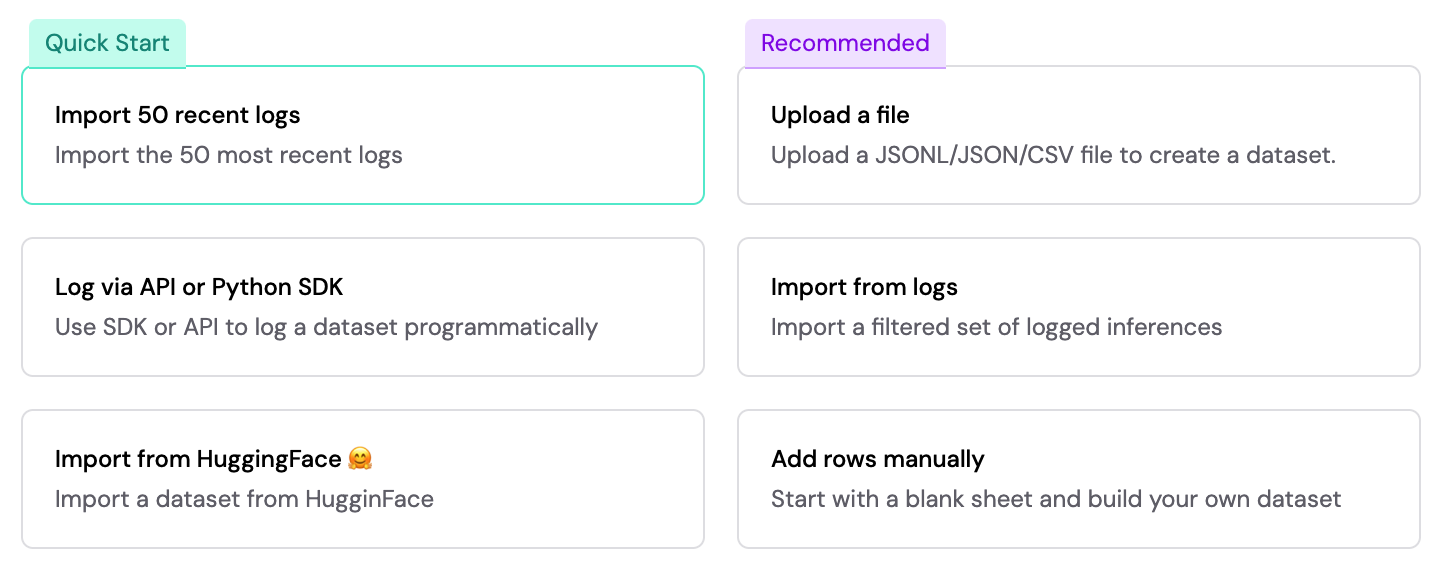

In [ ]:
#connect to Athina
from athina_client.datasets import Dataset
from athina_client.keys import AthinaApiKey

AthinaApiKey.set_key(os.environ['ATHINA_API_KEY'])

try:
    Dataset.add_rows(
        dataset_id='-',
        rows=rows
    )
except Exception as e:
    print(f"Failed to add rows: {e}")

After connecting the Athina SDK, you can access your data at https://app.athina.ai/develop/ {{your_data_id}}

And, you can run evaluations to test the performance of our Agentic RAG in the "Evaluate" button in the top right corner.

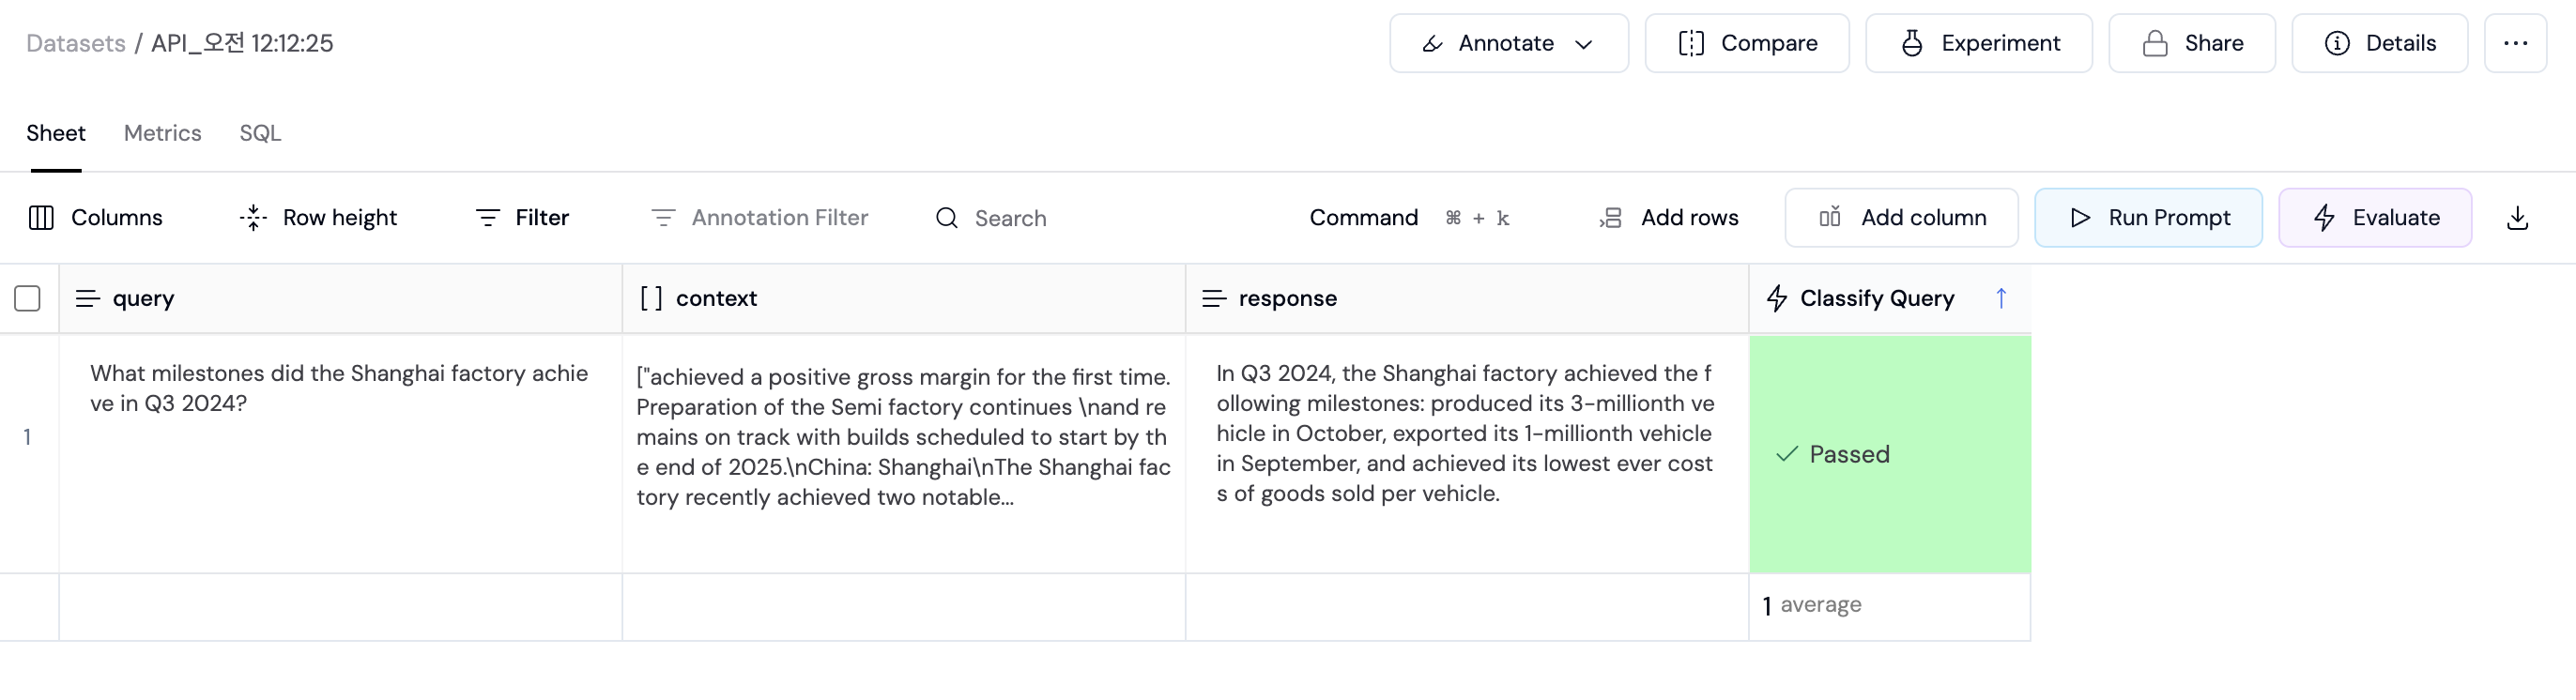